# Single Trace Analysis Notebook (in progress)
## DNAntenna Single Molecule Traces - Brownian Motion

In [18]:
# import necessary libraries
import os
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
from tweezepy import PSD
from scipy.signal import welch
import matplotlib.pyplot as plt

## Load the data

In [19]:
# TRACE PATH SETTINGS ##########
# load your trajectory into file_path, must be directly to an existing csv file
csv_number = '00000'
file_path = '/Users/laurentakiguchi/Desktop/DNAntenna-Code/data/20230724_antenna/RORE/0nM/638_1000hz_0004trcsv/' + csv_number + '.csv' 
exp_name = file_path.split('/')[-2]

# SAVE PATH SETTINGS #############
#save_figs = 1 # 1 = saves plots to folder, 0 = doesn't save plots
#save_folder = '/Users/laurentakiguchi/Desktop/' # where your plots will save
#os.makedirs(save_folder,exist_ok=True)

# CAMERA ACQUISITION SETTINGS ############
pixel_size = 108 # camera specific, 1 pixel = pixel_size nm
fsample = 1000 # in Hz or s^-1, acquisition framerate 
###################################
print('title as:',csv_number) # plot title and save handles, make sure it's right

title as: 00000


In [20]:
# data_raw: raw data dataframe, data_crop: cropped data dataframe
# returns xx (pos in pixels), yy (pos in pixels), c0int (integrated intensity), fitheight (height of gaussian), noise (bckg noise), SNR (fitheight/noise)
data_raw = pd.read_csv(file_path,names=['xx','yy','c0int','fitheight','noise','SNR'])
data_raw = data_raw[(data_raw['xx'] != 0) & (data_raw['yy'] != 0)] # drop zero values from dataframe
data_raw['xpos_nm'] = data_raw['xx']*pixel_size
data_raw['ypos_nm'] = data_raw['yy']*pixel_size
data_crop = data_raw.head(-300) # how many frames to crop dataframe by from end (head(10) removes last 10 frames)

## 1D Raw data w/downsampled overlay

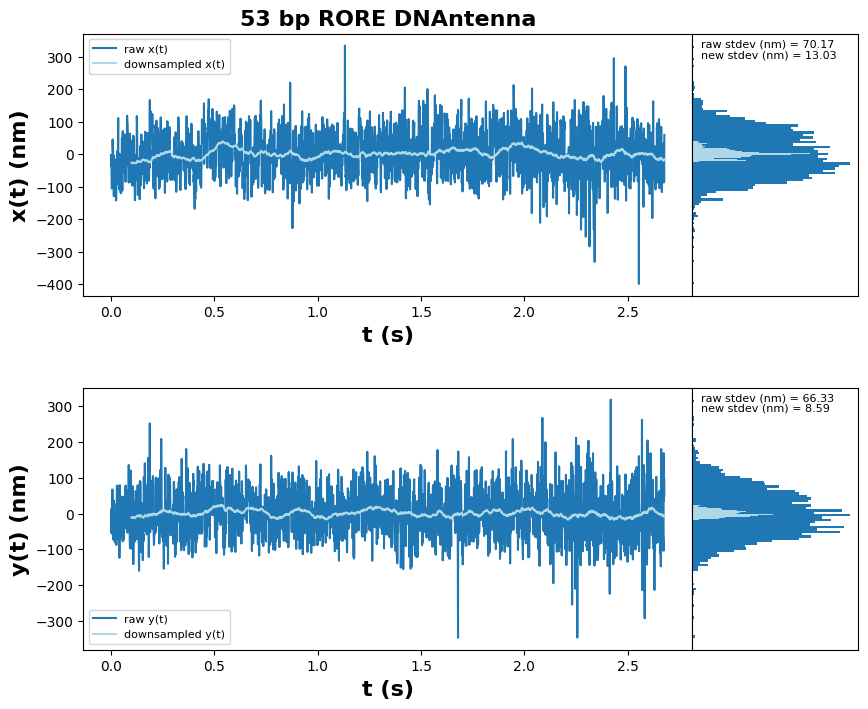

In [21]:
# 1D RAW DATA W/ DOWNSAMPLED OVERLAY PLOT ########
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8), ncols=2, nrows=2, gridspec_kw={'width_ratios': [2.75, .75], 'hspace': 0.35, 'wspace': 0})

x_com, y_com = data_crop['xpos_nm'].mean(), data_crop['ypos_nm'].mean() # centers peak on center of mass
dx, dy = data_crop['xpos_nm'] - x_com, data_crop['ypos_nm'] - y_com
N = len(data_crop['xpos_nm'])
time = np.arange(N) / fsample
# t_data_crop: cropped data centered relative to center of mass
t_data_crop = pd.DataFrame({'xpos_nm': data_crop['xpos_nm'], 'ypos_nm': data_crop['ypos_nm'], 'xpos_nm_t': dx, 'ypos_nm_t': dy,
                           'c0int': data_crop['c0int'], 'fitheight': data_crop['fitheight'], 'noise': data_crop['noise'], 'SNR': data_crop['SNR']})

for i in range(2): # plots x(t), y(t) at fsample
    ax[i, 0].plot(time, t_data_crop[f'{["xpos_nm_t", "ypos_nm_t"][i]}'], label=f'raw {["x(t)", "y(t)"][i]}')
    ax[i, 0].set_xlabel('t (s)', fontsize=16, fontweight='bold')
    ax[i, 0].set_ylabel(f'{["x(t) (nm)", "y(t) (nm)"][i]}', fontsize=16, fontweight='bold')
    ax[i, 0].legend(fontsize=8)

    hist = ax[i, 1].hist([dx, dy][i], bins=100, orientation='horizontal')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    std_val = np.std([t_data_crop['xpos_nm_t'], t_data_crop['ypos_nm_t']][i])
    ax[i, 1].annotate("raw stdev (nm) = {:.2f}".format(std_val), xy=(0.05, 0.98), xycoords='axes fraction', ha='left', va='top', fontsize=8)

# overlays downsampled trace at a frequency of choice
new_fsample = 10 # Hz
downsample_factor = int(fsample/new_fsample) # number of points to average in each window
downsampled_data = pd.DataFrame({
    'x': t_data_crop['xpos_nm_t'].rolling(window=downsample_factor).mean(),
    'y': t_data_crop['ypos_nm_t'].rolling(window=downsample_factor).mean()})
downsampled_time = np.linspace(0, len(t_data_crop)/fsample, len(downsampled_data['x']))

for i in range(2): # plots downsampled x(t), y(t) at new_fsample
    ax[i, 0].plot(downsampled_time, downsampled_data[['x', 'y'][i]], label=f'downsampled {["x(t)", "y(t)"][i]}', color='lightblue')
    hist = ax[i, 1].hist(downsampled_data[['x', 'y'][i]], bins=100, color='lightblue', orientation='horizontal')
    std_downsample = np.std([downsampled_data['x'], downsampled_data['y']][i])
    ax[i, 1].annotate('new stdev (nm) = {:.2f}'.format(std_downsample), xy=(0.05, 0.94), xycoords='axes fraction', ha='left', va='top', fontsize=8)

ax[0, 0].legend(fontsize=8)
ax[1, 0].legend(fontsize=8)
#ax[0, 0].set_title(f'Trace: {csv_number}, fs: {fsample} Hz\n Exp Name: {exp_name}', fontsize=20, fontweight='bold')
ax[0,0].set_title('53 bp RORE DNAntenna', fontsize=16, fontweight='bold')
plt.show()

## Compute PSD and fit Lorentzian

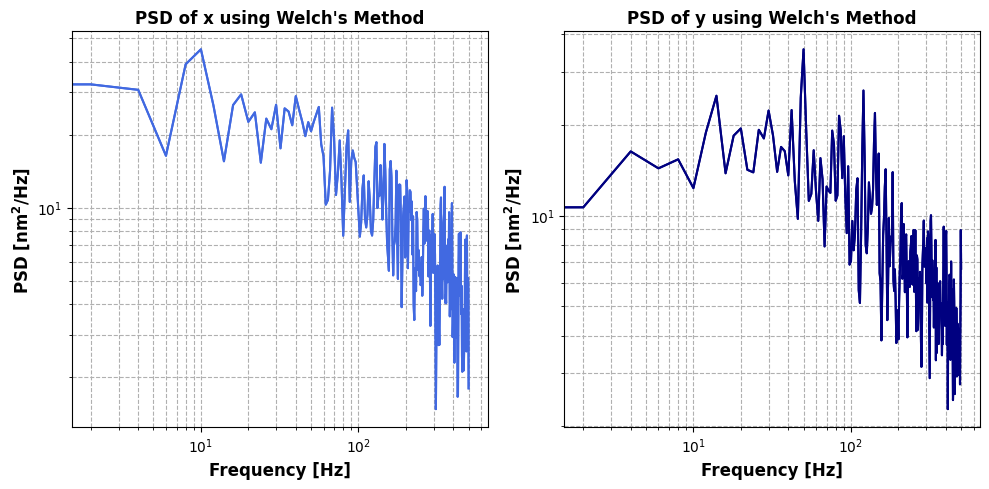

In [22]:
# PSDx + PSDy
fs = 1000  # sampling rate
psdtrace_x = t_data_crop['xpos_nm_t']
psdtrace_y = t_data_crop['ypos_nm_t']
N_psd = len(psdtrace_x)  # number of points in trajectory

# compute PSD with Welch's method for both x and y
f_x, Pxx = welch(psdtrace_x, fs, nperseg=fs//2, noverlap=fs//4)
f_y, Pyy = welch(psdtrace_y, fs, nperseg=fs//2, noverlap=fs//4)

# 1x2 subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# first subplot - PSDx
ax1.semilogy(f_x, Pxx, color='royalblue')
ax1.semilogx(f_x, Pxx, color='royalblue')
ax1.set_xlabel('Frequency [Hz]',fontweight='bold', fontsize=12)
ax1.set_ylabel(r'PSD [$\mathbf{nm^2/{Hz}}$]',fontweight='bold', fontsize=12)
ax1.set_title('PSD of x using Welch\'s Method', fontweight='bold', fontsize=12)
ax1.grid(True, which="both", ls="--")

# second subplot - PSDy
ax2.semilogy(f_y, Pyy, color='navy')
ax2.semilogx(f_y, Pyy, color='navy')
ax2.set_xlabel('Frequency [Hz]',fontweight='bold', fontsize=12)
ax2.set_ylabel('PSD [$\mathbf{nm^2/{Hz}}$]',fontweight='bold', fontsize=12)
ax2.set_title('PSD of y using Welch\'s Method', fontweight='bold', fontsize=12)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

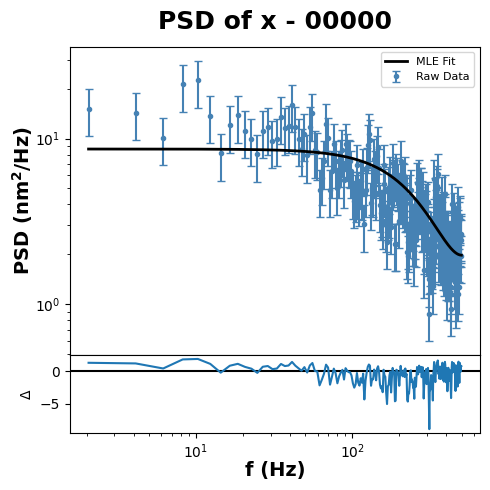

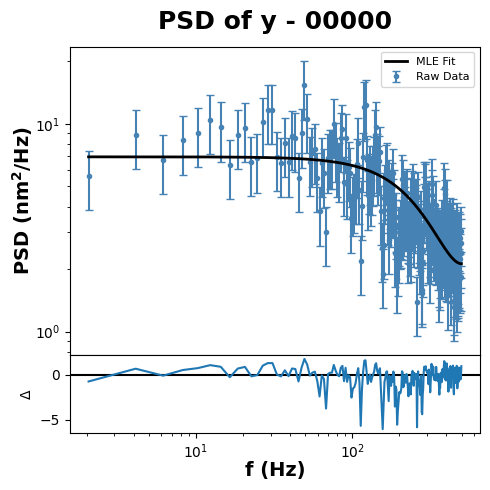

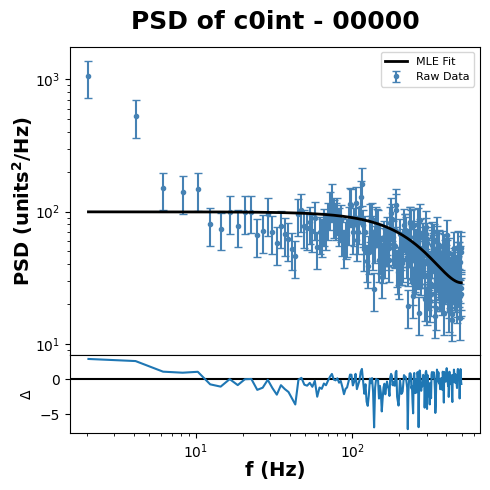

In [23]:
# 3x PSD (POWER SPECTRAL DENSITY) W/ FITTED LORENTZIAN PLOTS ###########
%matplotlib inline
binsize = 10 # can change this

#t_data_crop.dropna(inplace=True)
psdtrace_x = t_data_crop['xpos_nm_t']
psdtrace_y = t_data_crop['ypos_nm_t']
psdtrace_c0int = t_data_crop['c0int']
N_psd = len(psdtrace_x) # num points in trajectory
psdtrace_time = np.arange(N)/fsample # in s

psd_x = PSD(psdtrace_x,fsample,bins=binsize)
psd_y = PSD(psdtrace_y,fsample,bins=binsize)
psd_c0int = PSD(psdtrace_c0int,fsample,bins=binsize)
psd_x.mlefit()
psd_y.mlefit()
psd_c0int.mlefit()

fig,ax = psd_x.plot(data_label='Raw Data', fit_label='MLE Fit', data_color='steelblue')
ax[1].set_xlabel('f (Hz)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_ylabel(r'PSD ($\mathbf{nm^2/{Hz}}$)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_title('PSD of x - '+csv_number,fontsize=18,fontweight='bold',y=1.03)
ax[0].legend(fontsize=8)
fig.set_size_inches(5,5)
plt.tight_layout()
plt.show()

fig,ax = psd_y.plot(data_label='Raw Data', fit_label='MLE Fit', data_color='steelblue')
ax[1].set_xlabel('f (Hz)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_ylabel(r'PSD ($\mathbf{nm^2/{Hz}}$)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_title('PSD of y - '+csv_number,fontsize=18,fontweight='bold',y=1.03)
ax[0].legend(fontsize=8)
fig.set_size_inches(5,5)
plt.tight_layout()
plt.show()

fig,ax = psd_c0int.plot(data_label='Raw Data', fit_label='MLE Fit', data_color='steelblue')
ax[1].set_xlabel('f (Hz)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_ylabel(r'PSD ($\mathbf{units^2/{Hz}}$)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_title('PSD of c0int - '+csv_number,fontsize=18,fontweight='bold',y=1.03)
ax[0].legend(fontsize=8)
fig.set_size_inches(5,5)
plt.tight_layout()
plt.show()

## Gaussian KDE (kernel density estimation) plot

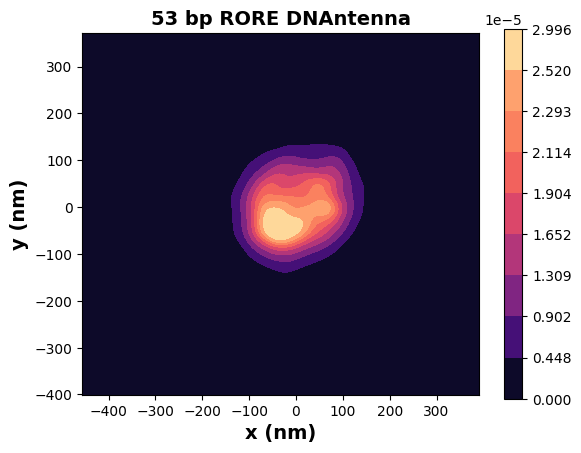

In [24]:
# 2D GAUSSIAN KDE PLOT ###########
%matplotlib inline

fig, ax = plt.subplots()
data = t_data_crop
x_kde = t_data_crop['xpos_nm_t']
y_kde = t_data_crop['ypos_nm_t']
kde = sns.kdeplot(data=data, x=x_kde, y=y_kde, cmap='magma', fill=True, thresh=0, cbar=True)
    
ax.set_xlabel('x (nm)',fontsize=14,fontweight='bold')
ax.set_ylabel('y (nm)',fontsize=14,fontweight='bold')
ax.set_aspect('equal')
#plt.title('KDE of Trace: '+csv_number+', fs: '+str(fsample)+' Hz\n Exp Name:'+exp_name, fontweight='bold', fontsize=16) 
plt.title('53 bp RORE DNAntenna',fontsize=14, fontweight='bold')
plt.show()

## 2D scatter plot

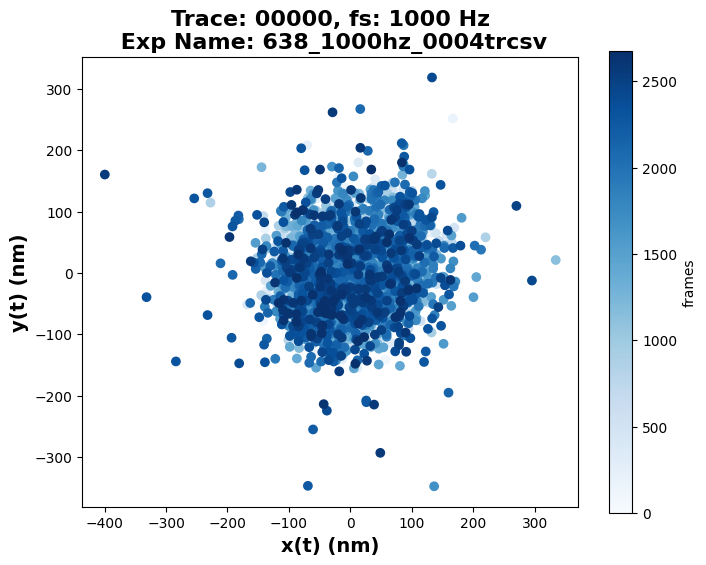

In [25]:
# 2D SCATTER PLOT ##########
%matplotlib inline
fig,ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(t_data_crop['xpos_nm_t'], t_data_crop['ypos_nm_t'], c=np.arange(len(t_data_crop)),cmap='Blues')
ax.set_xlabel('x(t) (nm)',fontweight='bold',fontsize=14)
ax.set_ylabel('y(t) (nm)',fontweight='bold',fontsize=14)
ax.set_aspect('equal')
ax.set_title(f'Trace: {csv_number}, fs: {fsample} Hz\n Exp Name: {exp_name}', fontsize=16, fontweight='bold')
plt.colorbar(scatter,ax=ax,label='frames')
plt.show()

## Integration Time Figure

In [26]:
# frequency-indepedent contribution of photon-limited localization uncertainty -> sigma of localizations
def sigma_localizations(mu_intensity): # input: mean intensity of trajectory
    sigma_loc_error = (981.1868/np.sqrt(mu_intensity)) - 6.2673 # in nm, equation coefficients determined by bead fit
    return sigma_loc_error

intensity_mean = np.mean(t_data_crop['c0int'])
sigma_localizations_nm = sigma_localizations(intensity_mean) # in nm
sigma_localizations_angular = np.rad2deg(np.arcsin(sigma_localizations_nm / (85+8.67))) # in degrees
epsilon = (2*(sigma_localizations_nm**2))/fsample # frequency-independent localization uncertainty constant

print('Sigma Localizations (deg):', sigma_localizations_angular)
print('Sigma Localizations (nm):', sigma_localizations_nm)
print('Epsilon:', epsilon)

Sigma Localizations (deg): 17.654829714287388
Sigma Localizations (nm): 28.408417126894363
Epsilon: 0.6233860244809698


In [27]:
kbT = 4.1 # pN nm at RT
kappa_axial = psd_x.results['k']
gamma_axial = psd_x.results['g']
tau_axial = gamma_axial/kappa_axial

In [28]:
# theoretical sigma of θ (brownian motion only)

def sigma_brownian_theoretical(t): # input: time vector
    sigma_theoretical_brownian = np.sqrt(
        (2*kbT/kappa_axial)* # constant factor
        (tau_axial/t - (tau_axial**2/t**2)* # time dependent factor
        (1-np.exp(-t/tau_axial)))) # exponential decay factor

    return sigma_theoretical_brownian

# theoretical sigma of θ (brownian motion + localization uncertainty)

def sigma_brownian_loc_theoretical(t, sigma_loc): # input: time vector, sigma of localizations
    sigma_theoretical_brownian_loc = np.sqrt(
        (2*kbT/kappa_axial)* # constant factor
        (tau_axial/t - (tau_axial**2/t**2)* # time dependent factor
        (1-np.exp(-t/tau_axial)))+ # exponential decay factor
        sigma_loc**2/(fsample*t)) # localization uncertainty factor

    return sigma_theoretical_brownian_loc

In [29]:
# calculates theoretical sigma of θ in 2 cases

integration_times_brownian = np.linspace(0.0005, 1, 10000) # in s
integration_times_brownian_loc = np.linspace(0.001, 1, 10000) # in s

integration_times_brownian_list = [] # initializes lists
sigma_theoretical_brownian_list = []
integration_times_brownian_loc_list = []
sigma_theoretical_brownian_loc_list = []

# iterates over the integration times and calculates angular sigma of θ for both cases

for integration_time in integration_times_brownian: # case 1: brownian motion only
    noloctheory_std = sigma_brownian_theoretical(integration_time)
    
    integration_times_brownian_list.append(integration_time)
    sigma_theoretical_brownian_list.append(noloctheory_std)
    
for integration_time in integration_times_brownian_loc: # case 2: brownian motion + localization uncertainty
    loctheory_std = sigma_brownian_loc_theoretical(integration_time,sigma_localizations_angular)
    
    integration_times_brownian_loc_list.append(integration_time)
    sigma_theoretical_brownian_loc_list.append(loctheory_std)

In [30]:
# ROLLING AVERAGE
# calculates experimental sigma of θ over different integration times via overlapping downsampling

integration_times_rolling_exp = np.linspace(0.001, 0.1, 100) # in s
rolling_downsampled_data = []

for integration_time in integration_times_rolling_exp:
    num_timepoints = int(integration_time / 0.001) # original data taken at 1 ms = 0.001 s exposure time
    rolling_downsampled = t_data_crop['xpos_nm_t'].rolling(num_timepoints).mean().dropna()
    average_value = np.std(rolling_downsampled) 
    rolling_downsampled_data.append(average_value)

In [31]:
# MOVING AVERAGE
# calculates experimental sigma of θ over different integration times via nonoverlapping downsampling

integration_times_exp = np.linspace(0.001, 0.1, 100) # in s
moving_downsampled_data = []

for integration_time in integration_times_exp:
    num_points = int(integration_time / 0.001) # number of points to average in each window
    moving_downsampled = t_data_crop['xpos_nm_t'].rolling(num_points).mean().iloc[num_points-1::num_points] # indexing ensures that subsets are non overlapping
    average_value = np.std(moving_downsampled) 
    moving_downsampled_data.append(average_value)

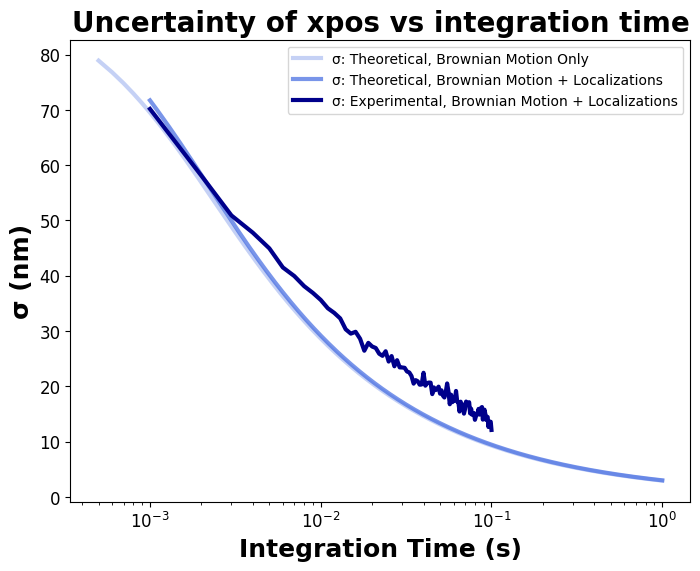

In [38]:
# INTEGRATION TIME FIGURE #########
# assuming sigma motion blur as negligible

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(integration_times_brownian_list, sigma_theoretical_brownian_list, color='royalblue',linewidth=3, label='σ: Theoretical, Brownian Motion Only', alpha=0.3)
ax.plot(integration_times_brownian_loc_list, sigma_theoretical_brownian_loc_list,linewidth=3,color='royalblue', label='σ: Theoretical, Brownian Motion + Localizations', alpha=0.7)

# plots the MOVING downsampled data 

ax.scatter(integration_times_exp, moving_downsampled_data, color='royalblue', s=1e-8) 
ax.plot(integration_times_exp, moving_downsampled_data,linewidth=3, color='darkblue', label='σ: Experimental, Brownian Motion + Localizations')  

ax.set_xscale('log')
ax.set_xlabel('Integration Time (s)', fontsize=18, fontweight='bold')
ax.set_ylabel('σ (nm)', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Uncertainty of xpos vs integration time', fontsize=20, fontweight='bold')
ax.legend(fontsize=10)

plt.show()

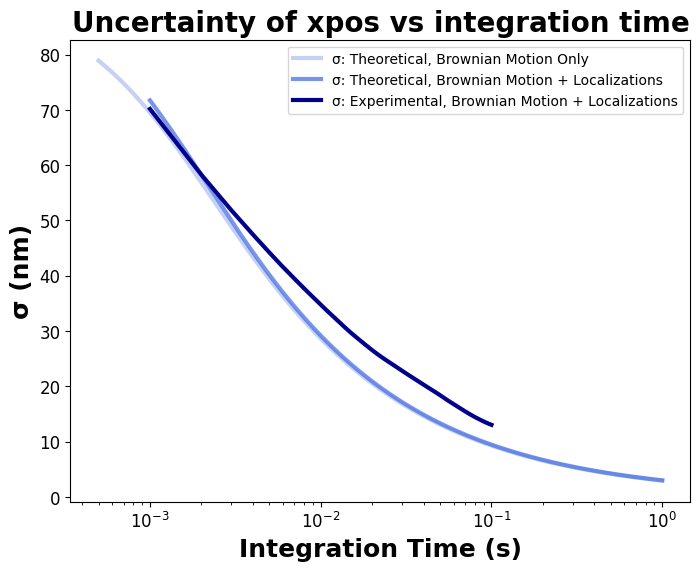

In [37]:
# assuming sigma motion blur as negligible

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(integration_times_brownian_list, sigma_theoretical_brownian_list, color='royalblue',linewidth=3, label='σ: Theoretical, Brownian Motion Only', alpha=0.3)
ax.plot(integration_times_brownian_loc_list, sigma_theoretical_brownian_loc_list,linewidth=3,color='royalblue', label='σ: Theoretical, Brownian Motion + Localizations', alpha=0.7)

# plots the ROLLING downsampled data

ax.scatter(integration_times_rolling_exp, rolling_downsampled_data, color='royalblue', s=1e-8)
ax.plot(integration_times_rolling_exp, rolling_downsampled_data,linewidth=3, color='darkblue', label='σ: Experimental, Brownian Motion + Localizations')

ax.set_xscale('log')
ax.set_xlabel('Integration Time (s)', fontsize=18, fontweight='bold')
ax.set_ylabel('σ (nm)', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Uncertainty of xpos vs integration time', fontsize=20, fontweight='bold')
ax.legend(fontsize=10)

plt.show()